# Introduction

### Headers
- Benchmark Name
- Total Depenedencies
- Dependencies Ratio
- Realizable (If one of the tools claims for realizability)
- (Tool name) Duration
- (Tool name) Status (ERROR | COMPLETED | TIMEOUT)

### Tools
 - Deps Synthesis (Synthesis 2 strategies: dependents, indepenents)
 - Spot Hijack (Don't find deps + don't eject)
 - Indep Synthesis (Synhesis a strategy only for independents, i.e., remove dependents from specification)
 - Spot Split-Determinstic (SD)
 - Spot LAR
 - Spot PS
 - Strix

### Sanity Check
- Realizability is similar in all tools

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import os.path
from pathlib import Path
import json
import re

In [2]:
def seconds_to_ms(secs):
    return secs * 1000

TIMEOUT_MS = seconds_to_ms(60*39) # 39 minutes

# Loading Results

### Deps Synthesis

In [3]:
# TODO: all paths extract to global const file
deps_synt_hoa_files = glob("../assets/aiger-synthesis/synt-with-deps/*.hoa")

def deps_synt_analysis(benchmark_name):
    hoa_file_path = "../assets/aiger-synthesis/synt-with-deps/{}.hoa".format(benchmark_name)
    json_file_path = "../assets/aiger-synthesis/synt-with-deps/{}.json".format(benchmark_name)
    hoa_file = Path(hoa_file_path).read_text()
    
    # If JSON file doesn't exist, it we had error in synthesis
    if not os.path.exists(json_file_path):
        status = 'error'
        error = ','.join(re.findall('Runtime error:(.*)', hoa_file))
        
        return {
            'name': benchmark_name,
            'status': 'error',
            'error': error
        }
    
    measures = json.loads(Path(json_file_path).read_text())
    
    duration = measures['total_time']
    status = 'completed' if measures['is_completed'] == True  else 'timeout'
    if status != 'completed':
        return {
            'name': benchmark_name,
            'status': status,
            'duration': duration,
        }
    
    total_dependents = sum((1 for v in measures['tested_variables'] if v['is_dependent']))
    total_outputs = len(measures['output_vars'])
    dependents_ratio = total_dependents / total_outputs
    realizablility = measures['synthesis']['independent_strategy']['realizability']
    independent_duration = measures['synthesis']['independent_strategy']['duration']
    dependent_duration = measures['synthesis']['dependent_strategy']['duration']
    
    return {
        'name': benchmark_name,
        'status': status,
        'duration': duration,
        'realizablility': realizablility,
        # 'independent_duration': independent_duration,
        # 'dependent_duration': dependent_duration,
        'dependents_ratio': dependents_ratio,
        'total_dependents': total_dependents
    }

deps_synt_df = pd.DataFrame([
    deps_synt_analysis(Path(benchmark_path).stem)
    for benchmark_path in deps_synt_hoa_files
])


deps_synt_df

,name,status,duration,realizablility,dependents_ratio,total_dependents,error
0,TwoCountersInRangeA4,completed,210.0,UNREALIZABLE,0.375000,3.0,NaN
1,ltl2dba05,completed,6.0,REALIZABLE,0.000000,0.0,NaN
2,ltl2dba11,completed,2.0,REALIZABLE,0.000000,0.0,NaN
3,TwoCountersDisButA6,completed,12926.0,UNREALIZABLE,0.307692,4.0,NaN
4,TorcsSteeringSimple,completed,5.0,REALIZABLE,0.333333,1.0,NaN
...,...,...,...,...,...,...,...
202,OneCounterGuiA1,completed,22.0,UNREALIZABLE,0.333333,3.0,NaN
203,EscalatorSmart,completed,8.0,REALIZABLE,0.333333,1.0,NaN
204,OneCounterGuiA0,completed,41.0,UNREALIZABLE,0.333333,3.0,NaN
205,ltl2dba20,completed,9.0,REALIZABLE,0.000000,0.0,NaN


In [4]:
deps_synt_df[deps_synt_df['status'] != 'completed']

,name,status,duration,realizablility,dependents_ratio,total_dependents,error
63,08,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
65,09,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
75,KitchenTimerV7,timeout,2399969.0,NaN,NaN,NaN,NaN
79,KitchenTimerV6,timeout,2400021.0,NaN,NaN,NaN,NaN
91,lilydemo18,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
141,13,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
142,07,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
144,06,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
145,12,error,NaN,NaN,NaN,NaN,Too many acceptance sets used. The limit is 32.
154,ltl2dpa22,timeout,2399977.0,NaN,NaN,NaN,NaN


### Indeps Only Synthesis

In [5]:
# TODO: all paths extract to global const file
indeps_synt_hoa_files = glob("../assets/aiger-synthesis/synt-indep/*.hoa")

def indeps_synt_analysis(benchmark_name):
    hoa_file_path = "../assets/aiger-synthesis/synt-indep/{}.hoa".format(benchmark_name)
    json_file_path = "../assets/aiger-synthesis/synt-indep/{}.json".format(benchmark_name)
    hoa_file = Path(hoa_file_path).read_text()
    
    # If JSON file doesn't exist, it we had error in synthesis
    if not os.path.exists(json_file_path):
        status = 'error'
        error = ','.join(re.findall('Runtime error:(.*)', hoa_file))
        
        return {
            'name': benchmark_name,
            'status': 'error',
            'error': error
        }
    
    measures = json.loads(Path(json_file_path).read_text())
    
    duration = measures['total_time']
    status = 'completed' if measures['is_completed'] == True  else 'timeout'
    if status != 'completed':
        return {
            'name': benchmark_name,
            'status': status,
            'duration': duration,
        }
    
    realizablility = measures['synthesis']['independent_strategy']['realizability']
    
    return {
        'name': benchmark_name,
        'status': status,
        'duration': duration,
        'realizablility': realizablility
    }

indeps_synt_df = pd.DataFrame([
    indeps_synt_analysis(Path(benchmark_path).stem)
    for benchmark_path in indeps_synt_hoa_files
])

indeps_synt_df

,name,status,duration,realizablility,error
0,TwoCountersInRangeA4,completed,208.0,UNREALIZABLE,NaN
1,ltl2dba05,completed,5.0,REALIZABLE,NaN
2,ltl2dba11,completed,2.0,REALIZABLE,NaN
3,TwoCountersDisButA6,completed,9135.0,UNREALIZABLE,NaN
4,TorcsSteeringSimple,completed,4.0,REALIZABLE,NaN
...,...,...,...,...,...
202,OneCounterGuiA1,completed,47.0,UNREALIZABLE,NaN
203,EscalatorSmart,completed,11.0,REALIZABLE,NaN
204,OneCounterGuiA0,completed,19.0,UNREALIZABLE,NaN
205,ltl2dba20,completed,9.0,REALIZABLE,NaN


### SPOT SD

In [6]:
# TODO: all paths extract to global const file
spot_sd_hoa_files = glob("../assets/aiger-synthesis/spot-sd/*.hoa")

def spot_sd_analysis(benchmark_name):
    hoa_file_path = "../assets/aiger-synthesis/spot-sd/{}.hoa".format(benchmark_name)
    hoa_file = Path(hoa_file_path).read_text()
    
    duration_str = re.findall('real\s+(.*)m(.*)s', hoa_file)
    if len(duration_str) != 1:
        raise Exception(f'Duration not found for benchmark {benchmark_name}, duration = ', duration)

    duration_minutes = float(duration_str[0][0])
    duration_seconds = float(duration_str[0][1])
    duration = seconds_to_ms(duration_seconds + (60*duration_minutes))
    
    is_completed = ('UNREALIZABLE' in hoa_file) or ('REALIZABLE' in hoa_file)
    if not is_completed:
        status = 'timeout' if duration >= TIMEOUT_MS else 'error'
        
        if status == 'error':
            error = ', '.join(re.findall('ltlsynt:(.*)', hoa_file))
        else:
            error = None
        
        return {
            'name': benchmark_name,
            'status': status,
            'error': error,
            'duration': duration
        }
    
    realizablility = 'UNREALIZABLE' if 'UNREALIZABLE' in hoa_file else 'REALIZABLE'
    return {
        'name': benchmark_name,
        'status': 'completed',
        'duration': duration,
        'realizablility': realizablility
    }

spot_sd_df = pd.DataFrame([
    spot_sd_analysis(Path(benchmark_path).stem)
    for benchmark_path in spot_sd_hoa_files
])

spot_sd_df

,name,status,duration,realizablility,error
0,TwoCountersInRangeA4,completed,2605.0,UNREALIZABLE,NaN
1,ltl2dba05,completed,35.0,REALIZABLE,NaN
2,ltl2dba11,completed,36.0,REALIZABLE,NaN
3,TwoCountersDisButA6,completed,2000596.0,UNREALIZABLE,NaN
4,TorcsSteeringSimple,completed,41.0,REALIZABLE,NaN
...,...,...,...,...,...
202,OneCounterGuiA1,completed,191.0,UNREALIZABLE,NaN
203,EscalatorSmart,completed,38.0,REALIZABLE,NaN
204,OneCounterGuiA0,completed,68.0,UNREALIZABLE,NaN
205,ltl2dba20,completed,37.0,REALIZABLE,NaN


In [7]:
spot_sd_df[spot_sd_df['status'] != 'completed']

,name,status,duration,realizablility,error
13,TwoCountersDisButAC,timeout,2400211.0,NaN,None
63,08,error,179.0,NaN,Too many acceptance sets used. The limit is 32.
65,09,error,157.0,NaN,Too many acceptance sets used. The limit is 32.
97,SensorSelector,timeout,2400285.0,NaN,None
115,LedMatrix,timeout,2400176.0,NaN,None
129,02,error,100.0,NaN,alternate_players(): Odd cycle detected.
131,03,error,2416.0,NaN,alternate_players(): Odd cycle detected.
141,13,error,185.0,NaN,Too many acceptance sets used. The limit is 32.
142,07,error,88.0,NaN,Too many acceptance sets used. The limit is 32.
144,06,error,170.0,NaN,Too many acceptance sets used. The limit is 32.


### SPOT Lar

In [8]:
# TODO: all paths extract to global const file
spot_lar_hoa_files = glob("../assets/aiger-synthesis/spot-lar/*.hoa")

def spot_lar_analysis(benchmark_name):
    hoa_file_path = "../assets/aiger-synthesis/spot-lar/{}.hoa".format(benchmark_name)
    hoa_file = Path(hoa_file_path).read_text()
    
    duration_str = re.findall('real\s+(.*)m(.*)s', hoa_file)
    if len(duration_str) != 1:
        raise Exception(f'Duration not found for benchmark {benchmark_name}, duration = ', duration)

    duration_minutes = float(duration_str[0][0])
    duration_seconds = float(duration_str[0][1])
    duration = seconds_to_ms(duration_seconds + (60*duration_minutes))
    
    is_completed = ('UNREALIZABLE' in hoa_file) or ('REALIZABLE' in hoa_file)
    if not is_completed:
        status = 'timeout' if duration >= TIMEOUT_MS else 'error'
        
        if status == 'error':
            error = ', '.join(re.findall('ltlsynt:(.*)', hoa_file))
        else:
            error = None
        
        return {
            'name': benchmark_name,
            'status': status,
            'error': error,
            'duration': duration
        }
    
    realizablility = 'UNREALIZABLE' if 'UNREALIZABLE' in hoa_file else 'REALIZABLE'
    return {
        'name': benchmark_name,
        'status': 'completed',
        'duration': duration,
        'realizablility': realizablility
    }

spot_lar_df = pd.DataFrame([
    spot_lar_analysis(Path(benchmark_path).stem)
    for benchmark_path in spot_lar_hoa_files
])

spot_lar_df

,name,status,duration,realizablility,error
0,TwoCountersInRangeA4,completed,2411.0,UNREALIZABLE,NaN
1,ltl2dba05,completed,32.0,REALIZABLE,NaN
2,ltl2dba11,completed,12.0,REALIZABLE,NaN
3,TwoCountersDisButA6,timeout,2402025.0,NaN,None
4,TorcsSteeringSimple,completed,20.0,REALIZABLE,NaN
...,...,...,...,...,...
202,OneCounterGuiA1,completed,93.0,UNREALIZABLE,NaN
203,EscalatorSmart,completed,41.0,REALIZABLE,NaN
204,OneCounterGuiA0,completed,90.0,UNREALIZABLE,NaN
205,ltl2dba20,completed,29.0,REALIZABLE,NaN


In [9]:
spot_lar_df[spot_lar_df['status'] != 'completed']

,name,status,duration,realizablility,error
3,TwoCountersDisButA6,timeout,2402025.0,NaN,None
6,TwoCountersDisButA7,timeout,2400986.0,NaN,None
13,TwoCountersDisButAC,timeout,2400156.0,NaN,None
63,08,error,217.0,NaN,Too many acceptance sets used. The limit is 32.
65,09,error,246.0,NaN,Too many acceptance sets used. The limit is 32.
97,SensorSelector,timeout,2400233.0,NaN,None
115,LedMatrix,timeout,2400113.0,NaN,None
141,13,error,216.0,NaN,Too many acceptance sets used. The limit is 32.
142,07,error,165.0,NaN,Too many acceptance sets used. The limit is 32.
144,06,error,190.0,NaN,Too many acceptance sets used. The limit is 32.


### Spot Hijacked

In [10]:
# TODO: all paths extract to global const file
spot_hijack_hoa_files = glob("../assets/aiger-synthesis/spot-hijack/*.hoa")

def spot_hijack_analysis(benchmark_name):
    hoa_file_path = "../assets/aiger-synthesis/spot-hijack/{}.hoa".format(benchmark_name)
    json_file_path = "../assets/aiger-synthesis/spot-hijack/{}.json".format(benchmark_name)
    hoa_file = Path(hoa_file_path).read_text()
    
    # If JSON file doesn't exist, it we had error in synthesis
    if not os.path.exists(json_file_path):
        status = 'error'
        error = ','.join(re.findall('Runtime error:(.*)', hoa_file))
        
        return {
            'name': benchmark_name,
            'status': 'error',
            'error': error
        }
    
    measures = json.loads(Path(json_file_path).read_text())
    
    duration = measures['total_time']
    status = 'completed' if measures['is_completed'] == True  else 'timeout'
    if status != 'completed':
        return {
            'name': benchmark_name,
            'duration': duration,
            'status': status,
        }
    
    realizablility = measures['synthesis']['independent_strategy']['realizability']
    
    return {
        'name': benchmark_name,
        'duration': duration,
        'status': status,
        'realizablility': realizablility
    }

spot_hijack_df = pd.DataFrame([
    spot_hijack_analysis(Path(benchmark_path).stem)
    for benchmark_path in spot_hijack_hoa_files
])


spot_hijack_df

,name,duration,status,realizablility,error
0,TwoCountersInRangeA4,319.0,completed,UNREALIZABLE,NaN
1,ltl2dba05,10.0,completed,REALIZABLE,NaN
2,ltl2dba11,2.0,completed,REALIZABLE,NaN
3,TwoCountersDisButA6,31231.0,completed,UNREALIZABLE,NaN
4,TorcsSteeringSimple,4.0,completed,REALIZABLE,NaN
...,...,...,...,...,...
202,OneCounterGuiA1,30.0,completed,UNREALIZABLE,NaN
203,EscalatorSmart,9.0,completed,REALIZABLE,NaN
204,OneCounterGuiA0,25.0,completed,UNREALIZABLE,NaN
205,ltl2dba20,9.0,completed,REALIZABLE,NaN


In [11]:
spot_hijack_df[spot_hijack_df['status'] != 'completed']

,name,duration,status,realizablility,error
63,08,NaN,error,NaN,Too many acceptance sets used. The limit is 32.
65,09,NaN,error,NaN,Too many acceptance sets used. The limit is 32.
75,KitchenTimerV7,2399991.0,timeout,NaN,NaN
79,KitchenTimerV6,2400015.0,timeout,NaN,NaN
91,lilydemo18,NaN,error,NaN,Too many acceptance sets used. The limit is 32.
115,LedMatrix,2400052.0,timeout,NaN,NaN
141,13,NaN,error,NaN,Too many acceptance sets used. The limit is 32.
142,07,NaN,error,NaN,Too many acceptance sets used. The limit is 32.
144,06,NaN,error,NaN,Too many acceptance sets used. The limit is 32.
145,12,NaN,error,NaN,Too many acceptance sets used. The limit is 32.


### Merging Tools

In [12]:
tools_df = {
    'deps': deps_synt_df, # Synthesis dependent and independent strategies
    'indeps': indeps_synt_df, # Synthesis strategy only for dependent variables
    'spot_hijack': spot_hijack_df, # Spot Hijack algorithm
    'spot_sd': spot_sd_df, # Spot SD algorithm
    'spot_lar': spot_lar_df, # Spot lar algorithm
}

In [46]:
A = pd.merge(
    tools_df['deps'],
    tools_df['indeps'],
    suffixes=('_deps', '_indeps'),
    on='name'
)
B = pd.merge(
    tools_df['spot_sd'],
    tools_df['spot_hijack'],
    suffixes=('_spot_sd', '_spot_hijack'),
    on='name'
)
all_tools_df = pd.merge(A, B, on='name')
C = tools_df['spot_lar'].copy().add_suffix('_spot_lar').rename(columns={'name_spot_lar': 'name'})
all_tools_df = pd.merge(all_tools_df, C, on='name')

def rowRealizable(row):
    realizabilities = row[[
        'realizablility_{}'.format(tool_name)
        for tool_name in tools_df.keys()
    ]].unique()
    
    for realizability in realizabilities:
        if realizability != None:
            return realizability
    
    return None

all_tools_df['realizability'] = all_tools_df.apply(rowRealizable, axis=1)
all_tools_df

,name,status_deps,duration_deps,realizablility_deps,dependents_ratio,total_dependents,error_deps,status_indeps,duration_indeps,realizablility_indeps,...,error_spot_sd,duration_spot_hijack,status_spot_hijack,realizablility_spot_hijack,error_spot_hijack,status_spot_lar,duration_spot_lar,realizablility_spot_lar,error_spot_lar,realizability
0,TwoCountersInRangeA4,completed,210.0,UNREALIZABLE,0.375000,3.0,NaN,completed,208.0,UNREALIZABLE,...,NaN,319.0,completed,UNREALIZABLE,NaN,completed,2411.0,UNREALIZABLE,NaN,UNREALIZABLE
1,ltl2dba05,completed,6.0,REALIZABLE,0.000000,0.0,NaN,completed,5.0,REALIZABLE,...,NaN,10.0,completed,REALIZABLE,NaN,completed,32.0,REALIZABLE,NaN,REALIZABLE
2,ltl2dba11,completed,2.0,REALIZABLE,0.000000,0.0,NaN,completed,2.0,REALIZABLE,...,NaN,2.0,completed,REALIZABLE,NaN,completed,12.0,REALIZABLE,NaN,REALIZABLE
3,TwoCountersDisButA6,completed,12926.0,UNREALIZABLE,0.307692,4.0,NaN,completed,9135.0,UNREALIZABLE,...,NaN,31231.0,completed,UNREALIZABLE,NaN,timeout,2402025.0,NaN,None,UNREALIZABLE
4,TorcsSteeringSimple,completed,5.0,REALIZABLE,0.333333,1.0,NaN,completed,4.0,REALIZABLE,...,NaN,4.0,completed,REALIZABLE,NaN,completed,20.0,REALIZABLE,NaN,REALIZABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,OneCounterGuiA1,completed,22.0,UNREALIZABLE,0.333333,3.0,NaN,completed,47.0,UNREALIZABLE,...,NaN,30.0,completed,UNREALIZABLE,NaN,completed,93.0,UNREALIZABLE,NaN,UNREALIZABLE
203,EscalatorSmart,completed,8.0,REALIZABLE,0.333333,1.0,NaN,completed,11.0,REALIZABLE,...,NaN,9.0,completed,REALIZABLE,NaN,completed,41.0,REALIZABLE,NaN,REALIZABLE
204,OneCounterGuiA0,completed,41.0,UNREALIZABLE,0.333333,3.0,NaN,completed,19.0,UNREALIZABLE,...,NaN,25.0,completed,UNREALIZABLE,NaN,completed,90.0,UNREALIZABLE,NaN,UNREALIZABLE
205,ltl2dba20,completed,9.0,REALIZABLE,0.000000,0.0,NaN,completed,9.0,REALIZABLE,...,NaN,9.0,completed,REALIZABLE,NaN,completed,29.0,REALIZABLE,NaN,REALIZABLE


In [14]:
all_tools_df.columns

Index(['name', 'status_deps', 'duration_deps', 'realizablility_deps',
       'dependents_ratio', 'total_dependents', 'error_deps', 'status_indeps',
       'duration_indeps', 'realizablility_indeps', 'error_indeps',
       'status_spot_sd', 'duration_spot_sd', 'realizablility_spot_sd',
       'error_spot_sd', 'duration_spot_hijack', 'status_spot_hijack',
       'realizablility_spot_hijack', 'error_spot_hijack', 'status_spot_lar',
       'duration_spot_lar', 'realizablility_spot_lar', 'error_spot_lar'],
      dtype='object')

In [50]:
tools_summary_df = all_tools_df[[
    'name', 'total_dependents', 'dependents_ratio', "realizability",
    'duration_deps', 'duration_indeps', 'duration_spot_sd', 'duration_spot_hijack', 'duration_spot_lar',
    'status_deps', 'status_indeps', 'status_spot_sd', 'status_spot_hijack', 'status_spot_lar',
]].copy()
tools_summary_df.rename(columns={
    "duration_{}".format(tool): tool + " Duration"
    for tool in tools_df.keys()
}, inplace=True)
tools_summary_df.rename(columns={
    "status_{}".format(tool): tool + " Status"
    for tool in tools_df.keys()
}, inplace=True)

tools_summary_df

,name,total_dependents,dependents_ratio,realizability,deps Duration,indeps Duration,spot_sd Duration,spot_hijack Duration,spot_lar Duration,deps Status,indeps Status,spot_sd Status,spot_hijack Status,spot_lar Status
0,TwoCountersInRangeA4,3.0,0.375000,UNREALIZABLE,210.0,208.0,2605.0,319.0,2411.0,completed,completed,completed,completed,completed
1,ltl2dba05,0.0,0.000000,REALIZABLE,6.0,5.0,35.0,10.0,32.0,completed,completed,completed,completed,completed
2,ltl2dba11,0.0,0.000000,REALIZABLE,2.0,2.0,36.0,2.0,12.0,completed,completed,completed,completed,completed
3,TwoCountersDisButA6,4.0,0.307692,UNREALIZABLE,12926.0,9135.0,2000596.0,31231.0,2402025.0,completed,completed,completed,completed,timeout
4,TorcsSteeringSimple,1.0,0.333333,REALIZABLE,5.0,4.0,41.0,4.0,20.0,completed,completed,completed,completed,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,OneCounterGuiA1,3.0,0.333333,UNREALIZABLE,22.0,47.0,191.0,30.0,93.0,completed,completed,completed,completed,completed
203,EscalatorSmart,1.0,0.333333,REALIZABLE,8.0,11.0,38.0,9.0,41.0,completed,completed,completed,completed,completed
204,OneCounterGuiA0,3.0,0.333333,UNREALIZABLE,41.0,19.0,68.0,25.0,90.0,completed,completed,completed,completed,completed
205,ltl2dba20,0.0,0.000000,REALIZABLE,9.0,9.0,37.0,9.0,29.0,completed,completed,completed,completed,completed


In [48]:
tools_summary_df.to_csv('./synthesis_results.csv')

# Sanity Validation

### Common Realizability
All the tools should report the same on realizability

In [15]:
realizability_df = pd.DataFrame()
for tool in tools_df.keys():
    realizability_df[tool] = all_tools_df["realizablility_" + tool]
realizability_df

,deps,indeps,spot_hijack,spot_sd,spot_lar
0,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE
1,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE
2,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE
3,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,NaN
4,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE
...,...,...,...,...,...
202,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE
203,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE
204,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE,UNREALIZABLE
205,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE,REALIZABLE


In [33]:
# How many benchmarks have different realizability?
realizability_df[realizability_df.apply(lambda x: x.nunique() > 1, axis=1)]

,deps,indeps,spot_hijack,spot_sd,spot_lar


# Performance Comparastion

## Tools status

In [17]:
status_df = all_tools_df[["name", "dependents_ratio"]].copy()
for tool in tools_df.keys():
    status_df[tool] = all_tools_df["status_" + tool]

status_df.head(3)

,name,dependents_ratio,deps,indeps,spot_hijack,spot_sd,spot_lar
0,TwoCountersInRangeA4,0.375,completed,completed,completed,completed,completed
1,ltl2dba05,0.000,completed,completed,completed,completed,completed
2,ltl2dba11,0.000,completed,completed,completed,completed,completed


In [18]:
status_df[status_df.apply(lambda x: x[tools_df.keys()].nunique() > 1, axis=1)]

,name,dependents_ratio,deps,indeps,spot_hijack,spot_sd,spot_lar
3,TwoCountersDisButA6,0.307692,completed,completed,completed,completed,timeout
6,TwoCountersDisButA7,0.307692,completed,completed,completed,completed,timeout
13,TwoCountersDisButAC,0.307692,completed,completed,completed,timeout,timeout
75,KitchenTimerV7,NaN,timeout,timeout,timeout,completed,completed
79,KitchenTimerV6,NaN,timeout,timeout,timeout,completed,completed
91,lilydemo18,NaN,error,error,error,completed,completed
97,SensorSelector,0.400000,completed,completed,completed,timeout,timeout
115,LedMatrix,0.407407,completed,completed,timeout,timeout,timeout
129,02,0.000000,completed,completed,completed,error,completed
131,03,0.000000,completed,completed,completed,error,completed


## Spot Hijacked vs Indeps Only 
How much removing dependent variables from specification improve the synthesis?

In [19]:
hijacked_vs_indeps_df = all_tools_df[["name","duration_spot_hijack", "status_spot_hijack","duration_indeps","status_indeps", "dependents_ratio"]]
hijacked_vs_indeps_df

,name,duration_spot_hijack,status_spot_hijack,duration_indeps,status_indeps,dependents_ratio
0,TwoCountersInRangeA4,319.0,completed,208.0,completed,0.375000
1,ltl2dba05,10.0,completed,5.0,completed,0.000000
2,ltl2dba11,2.0,completed,2.0,completed,0.000000
3,TwoCountersDisButA6,31231.0,completed,9135.0,completed,0.307692
4,TorcsSteeringSimple,4.0,completed,4.0,completed,0.333333
...,...,...,...,...,...,...
202,OneCounterGuiA1,30.0,completed,47.0,completed,0.333333
203,EscalatorSmart,9.0,completed,11.0,completed,0.333333
204,OneCounterGuiA0,25.0,completed,19.0,completed,0.333333
205,ltl2dba20,9.0,completed,9.0,completed,0.000000


### Different Status

In [20]:
hijacked_vs_indeps_df[hijacked_vs_indeps_df["status_spot_hijack"] != hijacked_vs_indeps_df["status_indeps"]]

,name,duration_spot_hijack,status_spot_hijack,duration_indeps,status_indeps,dependents_ratio
115,LedMatrix,2400052.0,timeout,46216.0,completed,0.407407


### Time comparison

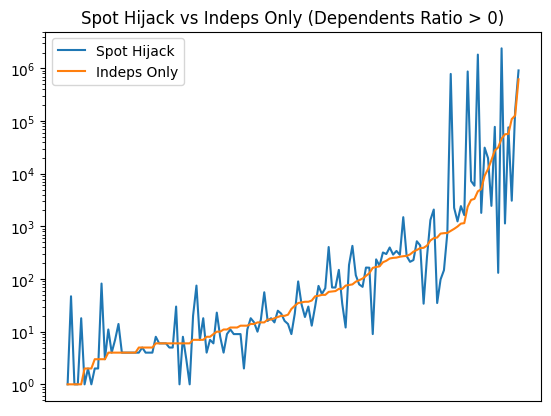

In [21]:
hijacked_vs_indeps_df_filtered = hijacked_vs_indeps_df[hijacked_vs_indeps_df["dependents_ratio"] > 0]
hijacked_vs_indeps_df_filtered = hijacked_vs_indeps_df_filtered.sort_values('duration_indeps')

fig, axs = plt.subplots()
axs.plot(hijacked_vs_indeps_df_filtered["name"], hijacked_vs_indeps_df_filtered["duration_spot_hijack"], label="Spot Hijack")
axs.plot(hijacked_vs_indeps_df_filtered["name"], hijacked_vs_indeps_df_filtered["duration_indeps"], label="Indeps Only")
axs.set_yscale("log")
axs.set_xticks([])
axs.set_title("Spot Hijack vs Indeps Only (Dependents Ratio > 0)")
axs.legend();

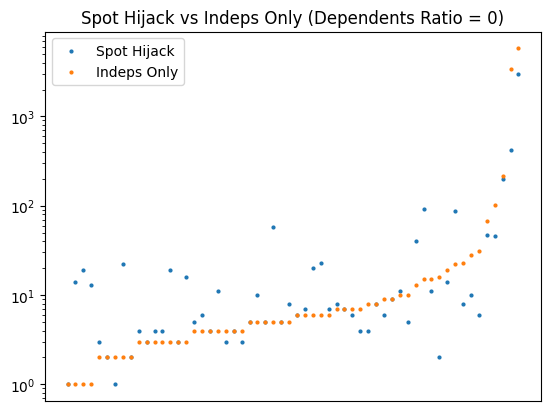

In [22]:
hijacked_vs_indeps_df_filtered = hijacked_vs_indeps_df[hijacked_vs_indeps_df["dependents_ratio"] == 0]
hijacked_vs_indeps_df_filtered = hijacked_vs_indeps_df_filtered.sort_values('duration_indeps')

fig, axs = plt.subplots()
axs.scatter(hijacked_vs_indeps_df_filtered["name"], hijacked_vs_indeps_df_filtered["duration_spot_hijack"], label="Spot Hijack", s=4)
axs.scatter(hijacked_vs_indeps_df_filtered["name"], hijacked_vs_indeps_df_filtered["duration_indeps"], label="Indeps Only", s=4)
axs.set_yscale("log")
axs.set_xticks([])
axs.set_title("Spot Hijack vs Indeps Only (Dependents Ratio = 0)")
axs.legend();